<a href="https://colab.research.google.com/github/pedromazim/visao/blob/main/project_fractal_dimension_texture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### I. Modules and auxiliary functions

In [ ]:
import numpy as np
import skimage as skm
import matplotlib.pyplot as pt
import matplotlib.colors as cm
#import porespy as ps
from numba import jit
from PIL import Image
import os
from glob import glob
from skimage.filters import threshold_otsu

In [ ]:
def make_gray(img, weights):

    '''
    converts an colored RGB image to grayscale

    img : image to be converted
    weights : list or array containing the relative weights of red, blue and green for conversion

    '''

    if len(img.shape) == 3:

        img_recol = np.zeros((img.shape[0],img.shape[1]))

        # for i in range(img.shape[0]):
        #     for j in range(img.shape[1]):
        #             img_recol[i,j] = weights[0]*img[i,j,0] + weights[1]*img[i,j,1] + weights[2]*img[i,j,2]
        img_recol = weights[0]*img[:,:,0] + weights[1]*img[:,:,1] + weights[2]*img[:,:,2]
        return img_recol
    else:
        return img

In [ ]:
@jit(looplift=True)
def histogram(img):

    '''
    returns the histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = np.zeros_like(bins)

    for b in bins:
        counts[b] = np.where(img==b)[0].size

    return counts

<ipython-input-3-8337ce144aa7>:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(looplift=True)


In [ ]:
@jit(looplift=True)
def cdf_histogram(img):

    '''
    returns the cummulative histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = histogram(img)
    cdf_counts = np.zeros_like(counts)

    for b in bins:
        cdf_counts[b] = np.sum(counts[0:b])/(img.size)

    return cdf_counts


<ipython-input-4-bddc8ff98c4a>:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(looplift=True)


In [ ]:
#@jit(looplift=True)
def otsu_thresholding(img):
    img = img.flatten()
    hist = histogram(img)
    cdf = cdf_histogram(hist)
    mean_gray = np.mean(img)
    var = np.zeros_like(hist)

    for t in range(256):
        # computing class probability (background and foreground)
        pb = img[img<t].size
        wb = pb/img.size
        wf = 1-wb

        if wb != 0 and wb != 1:
            mb = np.sum(img[img<t])/pb
            mf = np.sum(img[img>=t])/(img.size-pb)

            vb = np.sum((img[img<t]-mb)**2)/pb
            vf = np.sum((img[img>=t]-mf)**2)/(img.size-pb)

        elif wb == 1:
            continue
        else:
            continue

        var[t] = wb*vb + wf*vf
    count = 0
    for v in var:
        if v != 0:
            break
        else:
            count+=1
        #print(wb,vb, wf,vf, var[t])
    threshold = np.argmin(var[np.nonzero(var)]) + count

    return threshold

In [ ]:
# ROUBALHEIRA PESADA
@jit(looplift=True)
def find_divisors(num_a,num_b):# finds common divisors :)
    d_a, d_b = [],[]
    for i in range(2,int(num_a/2)+1):
        if num_a%i == 0:
            d_a.append(i)
    for i in range(2,int(num_b/2)+1):
        if num_b%i == 0:
            d_b.append(i)
    d = np.intersect1d(d_a,d_b)
    return np.array(d)

<ipython-input-6-00525284bd13>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(looplift=True)


In [ ]:
@jit(looplift=True)
def edt(img):# euclidean distance from foreground to background pixels

    img = img.astype('int')
    h, w = img.shape

    d = np.zeros((h,w))

    for y in range(h):
        for x in range(w):

            if img[x,y] == 1:
                flag = True
                r = 1
                while flag:
                    nb = img[x-r:x+r+1,y-r:y+r+1]
                    if np.flatnonzero(nb).size != nb.size:
                        d[x,y] = r
                        flag = False
                    else:
                        r += 1
    return d

<ipython-input-7-3228bbd79bae>:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(looplift=True)


In [ ]:
@jit(looplift=True)
def distance(img, x0, y0):# distance from all foreground pixels to a specific one
    img = img.astype('int')
    h, w = img.shape
    dist = np.zeros_like(img)
    fg = np.argwhere(img == 1)
    dist = np.sqrt((np.indices((h,w))[0]-x0)**2 + (np.indices((h,w))[1]-y0)**2)
    # for px in fg:
    #     dist[x,y] = np.sqrt((px[0]-x0)**2+(px[1]-y0)**2)
    return dist

<ipython-input-8-c6de0aadb2f4>:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(looplift=True)


In [ ]:
def make_square(img):
    # square = False
    # while not square:
    #     h, w = img.shape # height, width
    #     if w == h:
    #         square = True
    #     elif w > h:
    #         img = np.vstack((img, np.ones(w)*255))
    #     elif h>w:
    #         img = np.column_stack((img, np.ones(h)*255))
    h, w = img.shape # height, width

    if w > h:
        if w%2 != 0:
            img = np.column_stack((img, np.ones((h,1))*255))
            img = np.vstack((img, np.ones((w+1-h,w+1))*255))
        else:
            img = np.vstack((img, np.ones((w-h,w))*255))
    elif h > w:
        if h%2 != 0:
            img = np.vstack((img, np.ones((1,w))*255))
            img = np.column_stack((img, np.ones((h+1,h+1-w))*255))
        else:
            img = np.column_stack((img, np.ones((h,h-w))*255))
    return img


### II. Box-counting method

Input is a binary image\
Step 1: Cut the image in four squares (cut in half in width and height directions)\
Step 2: Count how many squares have at least one foreground pixel in it\
Step 3: Divide each square again and count


In [ ]:
#@jit(looplift=True)
def bcm(img, binary):
    if not binary:
        img = make_gray(img,[1/3,1/3,1/3])
        #thd = otsu_thresholding(img)
        thd = threshold_otsu(img)
        img = img > thd

        img = img.astype('int')
    grid = np.zeros_like(img)
    h, w = img.shape
    counts = []
    size = []

    for i in range(1,res):# divide squares each loop
        L = 2**(i)
        counter = 0
        for s in np.split(img,L):
            s = np.split(s,L,axis=1)
            for square in s:
                if np.flatnonzero(square).size != 0:
                    counter += 1
        counts.append(counter)

    counter = 0

    # for d in find_divisors(h,w):
    #     counter = 0
    #     size.append(int(h/d))
    #     s = img.reshape(d, int(h/d), d, int(w/d)).transpose(0,2,1,3)
    #     # print(s.shape)
    #     for ss in s:
    #         for square in ss:
    #             # print(square)
    #             if np.flatnonzero(square).size != 0:
    #                 counter += 1
    #     counts.append(counter)
    return [counts, size]

### III. Bouligand-Minkowsky method
Input is a binary image\
Step 1: Obtain the edge pixels by euclidean distance transform (EDT)\
Step 2: Set a disk of radius r and count every pixel under its influence area;\
Step 3: Repeat for every edge pixel;\
Step 4: Repeat for many r values;\
Step 5: Obtain FD by linearization of A(r) x r.

In [ ]:
def bmm(img, R):

    img = make_gray(img,[1/3,1/3,1/3])
    #thd = otsu_thresholding(img)
    thd = threshold_otsu(img)
    img = img > thd
    img = img.astype('int')

    dt = edt(img)
    edge = np.argwhere(dt==1)
    counts = []
    for r in range(1,R+1):# calculates influence area for multiple r values
        c = 0
        for px in edge:
            A_r = np.flatnonzero(np.where(distance(img, px[0],px[1]) <= r))
            c += A_r.size
        counts.append(c)

    return counts

### IV. Acquiring the dataset

In [ ]:
!git clone https://github.com/pedromazim/visao.git

Cloning into 'visao'...
remote: Enumerating objects: 504, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 504 (delta 42), reused 28 (delta 28), pack-reused 354
Receiving objects: 100% (504/504), 281.97 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Updating files: 100% (215/215), done.


In [ ]:
%cd visao/shapes99/
os.getcwd()

/content/visao/shapes99


'/content/visao/shapes99'

In [ ]:
filename_list = glob("*.png")

### V. Applying the methods to data

In [ ]:
#@jit(looplift=True)
def fd_dataset(filename_list): #calculates BCM and BMM for each image in dataset

    # BCM_fd = np.empty((22,len(filename_list)))
    # BMM_fd = np.empty((,len(filename_list)))
    out = open('out_shapes.dat','w')
    #BCM_fd = []
    BMM_fd = []
    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)

        # bcm_fd = bcm(img, True)
        # print(filename, 'bcm')
        bmm_fd = bmm(img, 100)
        print(filename, 'bmm')

        out.write(f'{bmm_fd}\n')
        # BCM_fd.append(bcm_fd)
        BMM_fd.append(bmm_fd)

    #data = np.savetxt('out_shapes.dat', np.array(BCM_fd))
    return BCM_fd, BMM_fd

In [ ]:
out_test_bcm = fd_dataset(filename_list)

<ipython-input-6-00525284bd13>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "find_divisors" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(int64, 1d, C))
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload in function 'impl_np_array': File: numba/np/arrayobj.py: Line 5384.
     With argument(s): '(array(int64, 1d, C))':
    Rejected as the implementation raised a specific error:
      TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    No implementation of function Function(<intrinsic np_array>) found for signature:
     
     >>> np_array(array(int64, 1d, C), none)
     
    There are 2 candidate implementations:
          - Of which 2 did not match due to:
          Intrinsic in function 'np_array': File: numba/np/arrayobj.py: Line 5358.
            With argument(s): '(array(in

0 bcm


<ipython-input-8-c6de0aadb2f4>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "distance" failed type inference due to: Use of unsupported NumPy function 'numpy.indices' or unsupported use of the function.

File "<ipython-input-8-c6de0aadb2f4>", line 7:
def distance(img, x0, y0):# distance from all foreground pixels to a specific one
    <source elided>
    fg = np.argwhere(img == 1)
    dist = np.sqrt((np.indices((h,w))[0]-x0)**2 + (np.indices((h,w))[1]-y0)**2)
    ^

During: typing of get attribute at <ipython-input-8-c6de0aadb2f4> (7)

File "<ipython-input-8-c6de0aadb2f4>", line 7:
def distance(img, x0, y0):# distance from all foreground pixels to a specific one
    <source elided>
    fg = np.argwhere(img == 1)
    dist = np.sqrt((np.indices((h,w))[0]-x0)**2 + (np.indices((h,w))[1]-y0)**2)
    ^

  @jit(looplift=True)
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "distance"

0 bmm
1 bcm
1 bmm
2 bcm
2 bmm
3 bcm
3 bmm
4 bcm
4 bmm
5 bcm
5 bmm
6 bcm
6 bmm
7 bcm
7 bmm
8 bcm
8 bmm
9 bcm
9 bmm
10 bcm
10 bmm
11 bcm
11 bmm
12 bcm
12 bmm
13 bcm
13 bmm
14 bcm
14 bmm
15 bcm
15 bmm
16 bcm
16 bmm
17 bcm
17 bmm
18 bcm
18 bmm
19 bcm
19 bmm
20 bcm
20 bmm
21 bcm
21 bmm
22 bcm
22 bmm
23 bcm
23 bmm
24 bcm
24 bmm
25 bcm
25 bmm
26 bcm
26 bmm
27 bcm
27 bmm
28 bcm
28 bmm
29 bcm
29 bmm
30 bcm
30 bmm
31 bcm
31 bmm
32 bcm
32 bmm
33 bcm
33 bmm
34 bcm
34 bmm
35 bcm
35 bmm
36 bcm
36 bmm
37 bcm
37 bmm
38 bcm
38 bmm
39 bcm
39 bmm
40 bcm
40 bmm
41 bcm
41 bmm
42 bcm
42 bmm
43 bcm
43 bmm
44 bcm
44 bmm
45 bcm
45 bmm
46 bcm
46 bmm
47 bcm
47 bmm
48 bcm
48 bmm
49 bcm
49 bmm
50 bcm
50 bmm
51 bcm
51 bmm
52 bcm
52 bmm
53 bcm
53 bmm
54 bcm
54 bmm
55 bcm
55 bmm
56 bcm
56 bmm
57 bcm
57 bmm
58 bcm
58 bmm
59 bcm
59 bmm
60 bcm
60 bmm
61 bcm
61 bmm
62 bcm
62 bmm
63 bcm
63 bmm
64 bcm
64 bmm
65 bcm
65 bmm
66 bcm
66 bmm
67 bcm
67 bmm
68 bcm
68 bmm
69 bcm
69 bmm
70 bcm
70 bmm
71 bcm
71 bmm
72 bcm
72 bmm
73 b

In [ ]:
out_test_bcm

([[[9, 23, 72, 185, 572, 1543], [45, 27, 15, 9, 5, 3]],
  [[4, 16, 61, 232, 871, 3323], [64, 32, 16, 8, 4, 2]],
  [[4, 16, 63, 238, 915, 3575], [64, 32, 16, 8, 4, 2]],
  [[4, 16, 62, 234, 885, 3383], [64, 32, 16, 8, 4, 2]],
  [[4, 48, 114, 182, 432, 4929], [77, 22, 14, 11, 7, 2]],
  [[4, 16, 64, 275, 1036, 3978], [68, 34, 17, 8, 4, 2]],
  [[4, 3579], [71, 2]],
  [[4, 9, 34, 422, 1553, 3408], [69, 46, 23, 6, 3, 2]],
  [[4, 9, 16, 36, 119, 138, 447, 976, 1700, 3761],
   [66, 44, 33, 22, 12, 11, 6, 4, 3, 2]],
  [[4, 16, 63, 238, 913, 3553], [64, 32, 16, 8, 4, 2]],
  [[4, 9, 16, 36, 63, 80, 142, 248, 309, 536, 1177, 2048, 4537],
   [72, 48, 36, 24, 18, 16, 12, 9, 8, 6, 4, 3, 2]],
  [[4, 9, 16, 25, 35, 61, 92, 131, 201, 345, 488, 742, 1289, 2833],
   [60, 40, 30, 24, 20, 15, 12, 10, 8, 6, 5, 4, 3, 2]],
  [[4, 16, 61, 222, 831, 3160], [64, 32, 16, 8, 4, 2]],
  [[4, 16, 57, 213, 816, 3172], [64, 32, 16, 8, 4, 2]],
  [[4, 9, 15, 25, 33, 56, 90, 121, 187, 326, 451, 698, 1204, 2648],
   [60, 40,

In [ ]:
lm_coeffs = []
for i in range(len(out_test_bcm)):
    counts, sizes = out_test_bcm[i][0],out_test_bcm[i][1]
    # print(counts,sizes)
    lm_coeffs.append(np.polyfit(np.log(sizes),np.log(counts),1))
lm_coeffs

[array([-1.89994848,  9.4132786 ]),
 array([-1.93480524,  9.45966004]),
 array([-1.95568741,  9.54034941]),
 array([-1.94014876,  9.48240432]),
 array([-1.9466284 ,  9.86404041]),
 array([-1.95435279,  9.66156275]),
 array([-1.90404317,  9.50262087]),
 array([-1.89653582,  9.44514147]),
 array([-1.95312379,  9.59864317]),
 array([-1.9541446 ,  9.53521302]),
 array([-1.95922915,  9.79672335]),
 array([-1.91712568,  9.2816416 ]),
 array([-1.91680962,  9.39244105]),
 array([-1.91642803,  9.3709098 ]),
 array([-1.89753287,  9.18368015]),
 array([-1.9956217,  9.9771873]),
 array([-1.91225214,  9.23873863]),
 array([-1.92985073,  9.4440702 ]),
 array([-1.87465657,  8.9391971 ]),
 array([-1.9509261 ,  9.52569855]),
 array([-1.95271724,  9.59692957]),
 array([-1.89363262,  9.38630787]),
 array([-1.88796024,  9.49615852]),
 array([-1.89625655,  9.38351484]),
 array([-1.86591719,  8.96380229]),
 array([-1.93779664,  9.47441824]),
 array([-1.88183627,  9.24967259]),
 array([-1.93066099,  9.322686

### VI. Generating data descriptors

In [ ]:
from scipy.interpolate import BSpline

In [ ]:
from scipy.fftpack import fft, ifft

In [ ]:
img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[0]}?raw=true')
img = make_square(img)

In [ ]:
test_bmm = bmm(img,100)

<ipython-input-26-4b4b9bbb2b34>:1: RuntimeWarning: divide by zero encountered in log
  pt.scatter(np.log(np.arange(100)),np.log(test_bmm))


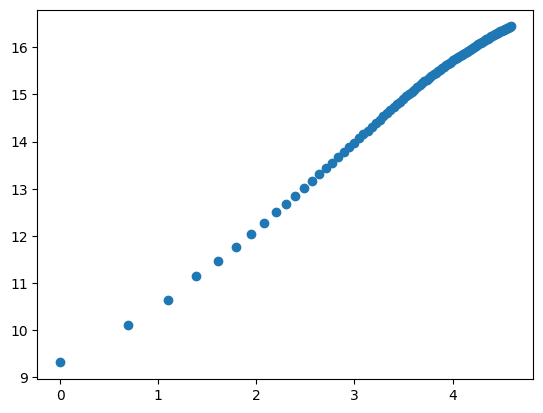

In [ ]:
pt.scatter(np.log(np.arange(100)),np.log(test_bmm))

In [ ]:
dbmm = np.polyfit(np.log(test_bmm),np.log(np.arange(100)),1)
DF_bmm = 2-dbmm

In [ ]:
#DIMENSAO FRACTAL MULTIESCALA
# DFM =  N - d(ln(A(r)))/dr
# e ai eu calculo essa derivada ai fazendo a diferecinha ponto a ponto e ai eu tenho duas metricas
# e com isso talvez ja de para classificar = plugar no classificador p fazer cluster.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


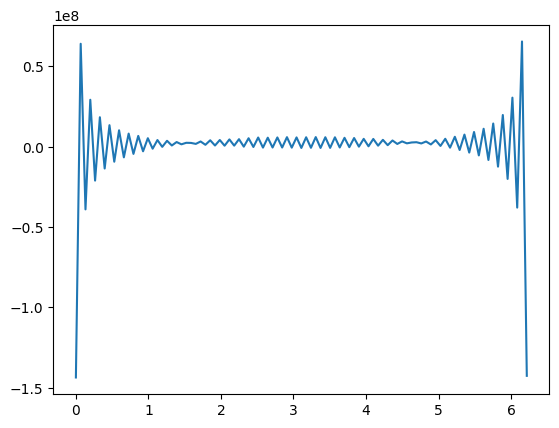

In [ ]:
pt.plot(x, dydx)

In [ ]:
perimeter = distance(img,) == 1

### VII. Classifying shapes by Principal Component Analysis (PCA)